In [1]:
import pandas as pd 
import numpy as np 
import os
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow_addons as tfa
import keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
categories = [str(x) for x in range(1,101)]
train_path = "UECFOOD100_CROP/UECFOOD100_CROP/train_all"
test_path =  "UECFOOD100_CROP/UECFOOD100_CROP/test_all"
multiple_labels_path = "labels/multiple_food.txt"
multiple_food = pd.DataFrame()

mlb = MultiLabelBinarizer(categories)

def build_multiple_food_df():
    with open(multiple_labels_path) as f:
        contents = f.read().split('\n')
        labels = []
        images = []
        for content in contents[1:]:
            label = content.split(" ")[1:]
            label = label[:len(label)-1]
            labels.append(label)
            images.append(content.split(" ")[0])

        multiple_food["image"] = images
        multiple_food["labels"] = labels

def build_category_files(df_path):
    category_files = []
    for category in categories:
        category_path = os.path.join(df_path, str(category))
        category_files = category_files + [os.path.join(str(category), i) for i in os.listdir(category_path) if os.path.isfile(os.path.join(category_path,i))]
    return category_files
        
def build_category_labels(category_files):
    category_labels = []
    for file in category_files:
        number = file.split("\\")[1].split(".jpg")[0]
        category = file.split("\\")[0]
        multiple = multiple_food[multiple_food['image'] == number]
        labels = []
        if len(multiple) > 0:
            labels = mlb.fit_transform(list(multiple_food[multiple_food['image'] == number]["labels"]))
        else:
            labels = mlb.fit_transform(list([[category]]))
        category_labels.append(labels[0])
    return category_labels
    


In [3]:
build_multiple_food_df()
print("Length of Multiple Food: " + str(len(multiple_food)))

Length of Multiple Food: 1174


In [4]:
for i in range(1,101):
    source_dir = 'UECFOOD100_CROP/UECFOOD100_CROP/train/' + str(i) 
    target_dir = 'UECFOOD100_CROP/UECFOOD100_CROP/train_all/' + str(i)

    file_names = os.listdir(source_dir)

    for file_name in file_names:
        number = file_name.split(".jpg")[0]
        multiple = multiple_food[multiple_food['image'] == number]

        if len(multiple) > 0:
            shutil.copy(os.path.join(source_dir, file_name), target_dir)

for i in range(1,101):
    source_dir = 'UECFOOD100_CROP/UECFOOD100_CROP/test/' + str(i) 
    target_dir = 'UECFOOD100_CROP/UECFOOD100_CROP/test_all/' + str(i)

    file_names = os.listdir(source_dir)

    for file_name in file_names:
        number = file_name.split(".jpg")[0]
        multiple = multiple_food[multiple_food['image'] == number]

        if len(multiple) > 0:
            shutil.copy(os.path.join(source_dir, file_name), target_dir)

In [5]:
# Train Images
train_category_files = build_category_files(train_path)
train_category_labels = build_category_labels(train_category_files)
train_df = pd.DataFrame(train_category_labels, columns=categories)
train_df["filename"] = train_category_files

# Test Images
test_category_files = build_category_files(test_path)
test_category_labels = build_category_labels(test_category_files)
test_df = pd.DataFrame(test_category_labels, columns=categories)
test_df["filename"] = test_category_files

In [6]:
print(train_df.shape)
print(test_df.shape)

(13938, 101)
(3522, 101)


In [7]:
train_df.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,filename
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\1.jpg
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10572_crop_0.jpg
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10586_crop_0.jpg
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10618_crop_0.jpg
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10621_crop_0.jpg


In [8]:
test_df.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,filename
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10617.jpg
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10617_crop_0.jpg
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10740_crop_0.jpg
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10_crop_0.jpg
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\11134_crop_0.jpg


## Image Loader and Augmentation

In [37]:
datagen=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.1)

In [38]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/train_all",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128),
subset="training"
)

Found 12545 validated image filenames.


In [39]:
test_gen=ImageDataGenerator(rescale=1./255)

validation_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/train_all",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128),
subset="validation")

test_generator=test_gen.flow_from_dataframe(
dataframe=test_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/test_all",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128))

Found 1393 validated image filenames.
Found 3522 validated image filenames.


## Model Training

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, utils

from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
from keras import backend as K
import keras_metrics as km

In [23]:
!python --version
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Python 3.8.8
Num GPUs Available 1


In [24]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### InceptionV3

In [40]:
optimizer = Adam(learning_rate = .001)

inception = InceptionV3(weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(x)
model = models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy',
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall(), f1])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_96 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                         

In [42]:
#With training and validation data
history1 = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    verbose=True,  callbacks=[early_stop, rlrop]
)

Epoch 1/50
393/393 [==============================] - 63s 149ms/step - loss: 0.1575 - categorical_accuracy: 0.2047 - binary_accuracy: 0.9862 - top_k_categorical_accuracy: 0.4377 - precision: 0.5226 - recall: 0.3295 - f1: 0.1529 - val_loss: 0.0928 - val_categorical_accuracy: 0.0294 - val_binary_accuracy: 0.9853 - val_top_k_categorical_accuracy: 0.2520 - val_precision: 0.6479 - val_recall: 0.2992 - val_f1: 0.2355 - lr: 0.0010
Epoch 2/50
393/393 [==============================] - 55s 139ms/step - loss: 0.0697 - categorical_accuracy: 0.2462 - binary_accuracy: 0.9881 - top_k_categorical_accuracy: 0.4945 - precision: 0.6595 - recall: 0.2794 - f1: 0.2088 - val_loss: 0.0864 - val_categorical_accuracy: 0.0725 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.3525 - val_precision: 0.6795 - val_recall: 0.2982 - val_f1: 0.3076 - lr: 0.0010
Epoch 3/50
393/393 [==============================] - 68s 173ms/step - loss: 0.0675 - categorical_accuracy: 0.2709 - binary_accuracy: 0.9882 - t

Epoch 15/50
393/393 [==============================] - 67s 171ms/step - loss: 0.0473 - categorical_accuracy: 0.4203 - binary_accuracy: 0.9896 - top_k_categorical_accuracy: 0.7160 - precision: 0.7687 - recall: 0.3611 - f1: 0.3782 - val_loss: 0.0710 - val_categorical_accuracy: 0.2814 - val_binary_accuracy: 0.9865 - val_top_k_categorical_accuracy: 0.4652 - val_precision: 0.7718 - val_recall: 0.3649 - val_f1: 0.3124 - lr: 5.0000e-04
Epoch 16/50
393/393 [==============================] - 63s 157ms/step - loss: 0.0470 - categorical_accuracy: 0.4289 - binary_accuracy: 0.9897 - top_k_categorical_accuracy: 0.7206 - precision: 0.7734 - recall: 0.3683 - f1: 0.3802 - val_loss: 0.0745 - val_categorical_accuracy: 0.1350 - val_binary_accuracy: 0.9863 - val_top_k_categorical_accuracy: 0.3733 - val_precision: 0.7751 - val_recall: 0.3707 - val_f1: 0.3538 - lr: 5.0000e-04
Epoch 17/50
393/393 [==============================] - 59s 151ms/step - loss: 0.0466 - categorical_accuracy: 0.4352 - binary_accuracy:

Epoch 33/50
393/393 [==============================] - 65s 164ms/step - loss: 0.0374 - categorical_accuracy: 0.5161 - binary_accuracy: 0.9906 - top_k_categorical_accuracy: 0.8069 - precision: 0.8077 - recall: 0.4114 - f1: 0.4671 - val_loss: 0.0743 - val_categorical_accuracy: 0.1479 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.3360 - val_precision: 0.8080 - val_recall: 0.4117 - val_f1: 0.3219 - lr: 1.2500e-04
Epoch 34/50
393/393 [==============================] - 68s 172ms/step - loss: 0.0372 - categorical_accuracy: 0.5188 - binary_accuracy: 0.9907 - top_k_categorical_accuracy: 0.8049 - precision: 0.8085 - recall: 0.4124 - f1: 0.4700 - val_loss: 0.0762 - val_categorical_accuracy: 0.1228 - val_binary_accuracy: 0.9851 - val_top_k_categorical_accuracy: 0.3151 - val_precision: 0.8088 - val_recall: 0.4125 - val_f1: 0.2914 - lr: 1.2500e-04
Epoch 35/50
393/393 [==============================] - 64s 163ms/step - loss: 0.0372 - categorical_accuracy: 0.5164 - binary_accuracy:

In [28]:
#2nd training
history2 = model.fit(train_generator,
                     steps_per_epoch=num_train_steps,
                    validation_data=validation_generator,
                     validation_steps=num_valid_steps,
                    epochs=50,
                    verbose=True,  callbacks=[early_stop, rlrop]
)

Epoch 1/50
87/87 [==============================] - 52s 596ms/step - loss: 0.0369 - categorical_accuracy: 0.5238 - binary_accuracy: 0.9904 - top_k_categorical_accuracy: 0.8178 - precision: 0.7966 - recall: 0.4333 - f1: 0.4426 - val_loss: 0.0749 - val_categorical_accuracy: 0.0718 - val_binary_accuracy: 0.9867 - val_top_k_categorical_accuracy: 0.2028 - val_precision: 0.7970 - val_recall: 0.4337 - val_f1: 0.2080 - lr: 3.1250e-05
Epoch 2/50
87/87 [==============================] - 52s 593ms/step - loss: 0.0367 - categorical_accuracy: 0.5211 - binary_accuracy: 0.9904 - top_k_categorical_accuracy: 0.8198 - precision: 0.7972 - recall: 0.4340 - f1: 0.4413 - val_loss: 0.0747 - val_categorical_accuracy: 0.0685 - val_binary_accuracy: 0.9868 - val_top_k_categorical_accuracy: 0.2158 - val_precision: 0.7974 - val_recall: 0.4343 - val_f1: 0.2223 - lr: 3.1250e-05
Epoch 3/50
87/87 [==============================] - 51s 587ms/step - loss: 0.0367 - categorical_accuracy: 0.5203 - binary_accuracy: 0.9903 -

87/87 [==============================] - 52s 593ms/step - loss: 0.0354 - categorical_accuracy: 0.5351 - binary_accuracy: 0.9906 - top_k_categorical_accuracy: 0.8284 - precision: 0.8048 - recall: 0.4443 - f1: 0.4548 - val_loss: 0.0737 - val_categorical_accuracy: 0.0751 - val_binary_accuracy: 0.9868 - val_top_k_categorical_accuracy: 0.2188 - val_precision: 0.8051 - val_recall: 0.4445 - val_f1: 0.2256 - lr: 1.5625e-05
Epoch 20/50
87/87 [==============================] - 51s 587ms/step - loss: 0.0355 - categorical_accuracy: 0.5332 - binary_accuracy: 0.9905 - top_k_categorical_accuracy: 0.8305 - precision: 0.8053 - recall: 0.4448 - f1: 0.4479 - val_loss: 0.0742 - val_categorical_accuracy: 0.0804 - val_binary_accuracy: 0.9868 - val_top_k_categorical_accuracy: 0.2042 - val_precision: 0.8056 - val_recall: 0.4453 - val_f1: 0.2203 - lr: 1.5625e-05
Epoch 21/50
87/87 [==============================] - 52s 593ms/step - loss: 0.0355 - categorical_accuracy: 0.5356 - binary_accuracy: 0.9905 - top_k_ca

In [113]:
# precision is indicating if model tendency to predict 0 as 1 (False positive) 
# recall is indicating if model tendency to predict 1 as 0 (False Negative) => this is more likely to happen than the above

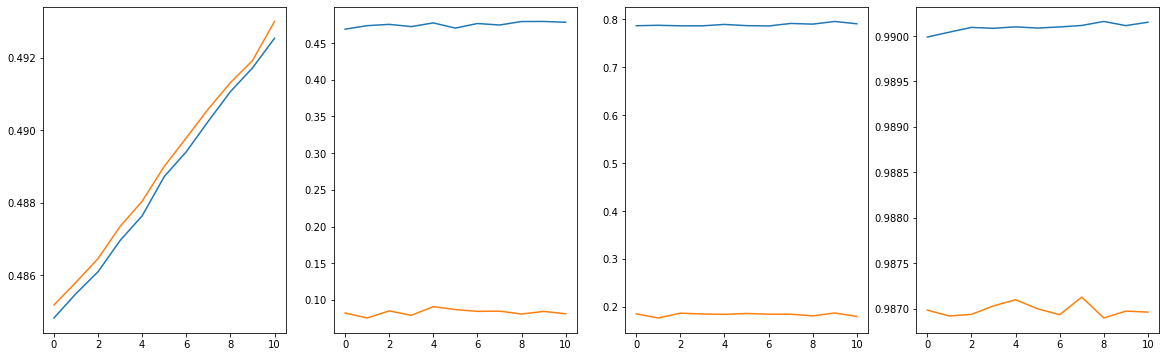

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes[0].plot(history2.history['recall'])
axes[0].plot(history2.history['val_recall'])
axes[1].plot(history2.history['categorical_accuracy'])
axes[1].plot(history2.history['val_categorical_accuracy'])
axes[2].plot(history2.history['top_k_categorical_accuracy'])
axes[2].plot(history2.history['val_top_k_categorical_accuracy'])
axes[3].plot(history2.history['binary_accuracy'])
axes[3].plot(history2.history['val_binary_accuracy'])

In [31]:
model.evaluate(test_generator)

28/28 [==============================] - 7s 228ms/step - loss: 0.0441 - categorical_accuracy: 0.4344 - binary_accuracy: 0.9897 - top_k_categorical_accuracy: 0.6905 - precision: 0.8117 - recall: 0.4529 - f1: 0.4159


[0.044092390686273575,
 0.43441227078437805,
 0.9896990060806274,
 0.6905167698860168,
 0.8116761445999146,
 0.4529198110103607,
 0.41588854789733887]

In [43]:
model.evaluate(test_generator)

111/111 [==============================] - 12s 107ms/step - loss: 0.0382 - categorical_accuracy: 0.5071 - binary_accuracy: 0.9905 - top_k_categorical_accuracy: 0.7751 - precision: 0.8230 - recall: 0.4275 - f1: 0.4840


[0.038158662617206573,
 0.5070982575416565,
 0.9904651641845703,
 0.7751277685165405,
 0.822999894618988,
 0.4274682104587555,
 0.4840374290943146]

In [126]:
# serialize model to JSON
model_json = model.to_json()
with open("uec100_inceptv3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("uec100_inceptv3.h5")
print("Saved model to disk")



Saved model to disk


In [127]:
from keras.models import model_from_json
json_file = open('uec100_inceptv3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_inceptv3.h5")
print("Loaded model from disk")

Loaded model from disk


In [119]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy',
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall()])

In [25]:
test_generator.reset()
pred=model.predict_generator(test_generator,
verbose=1)

pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=categories)
results["filename"]=test_generator.filenames
ordered_cols=["filename"]+categories
results=results[ordered_cols]#To get the same column order

28/28 [==============================] - 8s 250ms/step


In [29]:
img =load_img('web_pics/10_crop_0.jpg', target_size=(128,128))

98


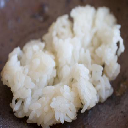

In [30]:
preds = model.predict(np.array([img_to_array(img)/255]))
print(np.argmax(preds[0]))
img

## VGG16


In [32]:
optimizer = Adam(learning_rate = .001)

vgg = VGG16(weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False
    
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(x)
model = models.Model(inputs=vgg.input, outputs=predictions)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy', 
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall(), f1])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [33]:
#With training and validation data
history1 = model.fit(train_generator, validation_data=validation_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
88/88 [==============================] - 85s 831ms/step - loss: 0.3865 - categorical_accuracy: 0.1630 - binary_accuracy: 0.9801 - top_k_categorical_accuracy: 0.3845 - precision: 0.4585 - recall: 0.3199 - f1: 0.1032 - val_loss: 0.1861 - val_categorical_accuracy: 0.0032 - val_binary_accuracy: 0.9866 - val_top_k_categorical_accuracy: 0.1058 - val_precision: 0.6012 - val_recall: 0.2599 - val_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/50
88/88 [==============================] - 54s 606ms/step - loss: 0.0676 - categorical_accuracy: 0.1831 - binary_accuracy: 0.9879 - top_k_categorical_accuracy: 0.4274 - precision: 0.6248 - recall: 0.2351 - f1: 0.1326 - val_loss: 0.1146 - val_categorical_accuracy: 0.0416 - val_binary_accuracy: 0.9871 - val_top_k_categorical_accuracy: 0.1335 - val_precision: 0.6637 - val_recall: 0.2572 - val_f1: 0.1016 - lr: 0.0010
Epoch 3/50
88/88 [==============================] - 54s 608ms/step - loss: 0.0639 - categorical_accuracy: 0.1989 - binary_accuracy: 0.9880 - top

88/88 [==============================] - 54s 608ms/step - loss: 0.0535 - categorical_accuracy: 0.3260 - binary_accuracy: 0.9887 - top_k_categorical_accuracy: 0.6193 - precision: 0.7418 - recall: 0.3790 - f1: 0.2705 - val_loss: 0.0833 - val_categorical_accuracy: 0.0700 - val_binary_accuracy: 0.9868 - val_top_k_categorical_accuracy: 0.1424 - val_precision: 0.7434 - val_recall: 0.3806 - val_f1: 0.2028 - lr: 0.0010
Epoch 16/50
88/88 [==============================] - 54s 614ms/step - loss: 0.0532 - categorical_accuracy: 0.3290 - binary_accuracy: 0.9887 - top_k_categorical_accuracy: 0.6198 - precision: 0.7454 - recall: 0.3832 - f1: 0.2759 - val_loss: 0.0869 - val_categorical_accuracy: 0.0043 - val_binary_accuracy: 0.9862 - val_top_k_categorical_accuracy: 0.1245 - val_precision: 0.7471 - val_recall: 0.3828 - val_f1: 0.1728 - lr: 0.0010
Epoch 17/50
88/88 [==============================] - 57s 647ms/step - loss: 0.0523 - categorical_accuracy: 0.3416 - binary_accuracy: 0.9887 - top_k_categorica

Epoch 33/50
88/88 [==============================] - 54s 609ms/step - loss: 0.0433 - categorical_accuracy: 0.4226 - binary_accuracy: 0.9895 - top_k_categorical_accuracy: 0.7291 - precision: 0.7827 - recall: 0.4284 - f1: 0.3529 - val_loss: 0.0797 - val_categorical_accuracy: 0.0649 - val_binary_accuracy: 0.9871 - val_top_k_categorical_accuracy: 0.1557 - val_precision: 0.7830 - val_recall: 0.4286 - val_f1: 0.2092 - lr: 2.5000e-04
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.0429 - categorical_accuracy: 0.4281 - binary_accuracy: 0.9895 - top_k_categorical_accuracy: 0.7398 - precision: 0.7838 - recall: 0.4294 - f1: 0.3558
Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
88/88 [==============================] - 54s 606ms/step - loss: 0.0429 - categorical_accuracy: 0.4281 - binary_accuracy: 0.9895 - top_k_categorical_accuracy: 0.7398 - precision: 0.7838 - recall: 0.4294 - f1: 0.3558 - val_loss: 0.0801 - val_categorical_accuracy: 0.0391 

In [34]:
# 2nd training
history2 = model.fit(train_generator, validation_data=validation_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
88/88 [==============================] - 54s 615ms/step - loss: 0.0419 - categorical_accuracy: 0.4476 - binary_accuracy: 0.9896 - top_k_categorical_accuracy: 0.7580 - precision: 0.7909 - recall: 0.4368 - f1: 0.3479 - val_loss: 0.0774 - val_categorical_accuracy: 0.0671 - val_binary_accuracy: 0.9873 - val_top_k_categorical_accuracy: 0.1604 - val_precision: 0.7914 - val_recall: 0.4374 - val_f1: 0.2312 - lr: 6.2500e-05
Epoch 2/50
88/88 [==============================] - 54s 605ms/step - loss: 0.0415 - categorical_accuracy: 0.4514 - binary_accuracy: 0.9896 - top_k_categorical_accuracy: 0.7673 - precision: 0.7921 - recall: 0.4383 - f1: 0.3493 - val_loss: 0.0783 - val_categorical_accuracy: 0.0560 - val_binary_accuracy: 0.9871 - val_top_k_categorical_accuracy: 0.1503 - val_precision: 0.7925 - val_recall: 0.4385 - val_f1: 0.2029 - lr: 6.2500e-05
Epoch 3/50
88/88 [==============================] - 54s 609ms/step - loss: 0.0413 - categorical_accuracy: 0.4565 - binary_accuracy: 0.9896 -

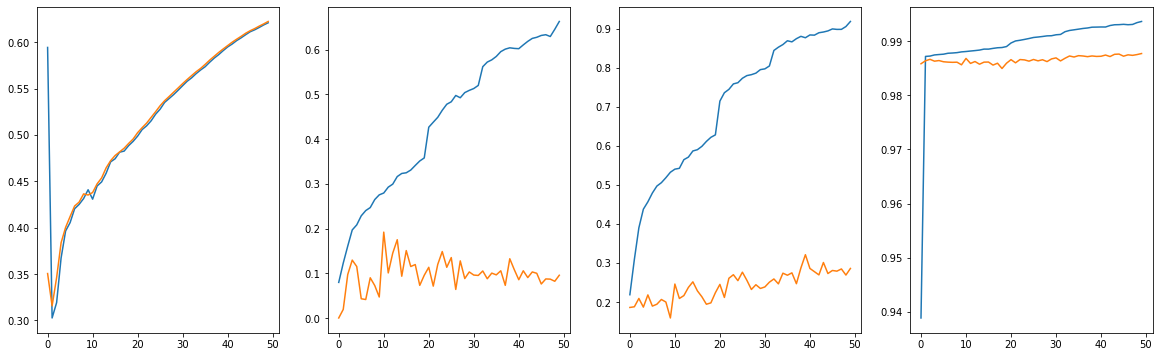

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes[0].plot(history2['recall'])
axes[0].plot(history2['val_recall'])
axes[1].plot(history2['categorical_accuracy'])
axes[1].plot(history2['val_categorical_accuracy'])
axes[2].plot(history2['top_k_categorical_accuracy'])
axes[2].plot(history2['val_top_k_categorical_accuracy'])
axes[3].plot(history2['binary_accuracy'])
axes[3].plot(history2['val_binary_accuracy'])

In [35]:
model.evaluate(test_generator)

28/28 [==============================] - 32s 1s/step - loss: 0.0492 - categorical_accuracy: 0.3907 - binary_accuracy: 0.9891 - top_k_categorical_accuracy: 0.6371 - precision: 0.8031 - recall: 0.4505 - f1: 0.3428


[0.04916927218437195,
 0.39068710803985596,
 0.9890971183776855,
 0.6371380090713501,
 0.8031282424926758,
 0.4504821002483368,
 0.3428325951099396]

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("uec100_VGG16.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("uec100_VGG16.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
from keras.models import model_from_json
json_file = open('uec100_VGG16.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_VGG16.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
test_generator.reset()
pred=model.predict_generator(test_generator,
verbose=1)

pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=categories)
results["filename"]=test_generator.filenames
ordered_cols=["filename"]+categories
results=results[ordered_cols]#To get the same column order

91/91 [==============================] - 13s 140ms/step


In [33]:
img =load_img('web_pics/fishpastry.jpg', target_size=(128,128))

77


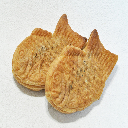

In [34]:
preds = loaded_model.predict(np.array([img_to_array(img)/255]))
print(np.argmax(preds[0]))
img

## Image Loader and Without Augmentation

In [37]:
no_augment_datagen=ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255)

train_gen_no_augment = no_augment_datagen.flow_from_dataframe(   
    dataframe=train_df,
    directory="./UECFOOD100_CROP/UECFOOD100_CROP/train",
    x_col="filename",
    y_col=categories,
    shuffle=False,
    batch_size=32,
    seed=42,
    class_mode="raw",
    target_size=(128,128),
    subset="training")

val_gen_no_augment=no_augment_datagen.flow_from_dataframe(
dataframe=train_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/train",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128),
subset="validation")

test_gen_no_augment = no_augment_datagen.flow_from_dataframe(   
    dataframe=test_df,
    directory="./UECFOOD100_CROP/UECFOOD100_CROP/test",
    x_col="filename",
    y_col=categories,
    shuffle=False,
    batch_size=32,
    seed=42,
    class_mode="raw",
    target_size=(128,128))

Found 9212 validated image filenames.
Found 2302 validated image filenames.
Found 2902 validated image filenames.


In [36]:
optimizer = Adam(learning_rate = .001)

inception = InceptionV3(weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = BatchNormalization()(x)

predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(x)
model = models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy',
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall()])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_103 (Batch  (None, None, None,   96         ['conv2d_94[0][0]']              
 Normalization)                 32)                                                         

In [38]:
#With training and validation data
history3 = model.fit(train_gen_no_augment,
                    validation_data=val_gen_no_augment,
                    epochs=50,
                    verbose=True,  callbacks=[early_stop, rlrop]
)

Epoch 1/50
288/288 [==============================] - 50s 163ms/step - loss: 0.3715 - categorical_accuracy: 0.0326 - binary_accuracy: 0.9330 - top_k_categorical_accuracy: 0.1021 - precision: 0.1287 - recall: 0.3342 - val_loss: 0.1514 - val_categorical_accuracy: 0.1403 - val_binary_accuracy: 0.9852 - val_top_k_categorical_accuracy: 0.1985 - val_precision: 0.1732 - val_recall: 0.1366 - lr: 0.0010
Epoch 2/50
288/288 [==============================] - 46s 161ms/step - loss: 0.1332 - categorical_accuracy: 0.0325 - binary_accuracy: 0.9868 - top_k_categorical_accuracy: 0.0952 - precision: 0.2016 - recall: 0.1119 - val_loss: 0.1256 - val_categorical_accuracy: 0.0673 - val_binary_accuracy: 0.9857 - val_top_k_categorical_accuracy: 0.1338 - val_precision: 0.2262 - val_recall: 0.0967 - lr: 0.0010
Epoch 3/50
288/288 [==============================] - 39s 137ms/step - loss: 0.1172 - categorical_accuracy: 0.0361 - binary_accuracy: 0.9866 - top_k_categorical_accuracy: 0.0970 - precision: 0.2800 - reca

288/288 [==============================] - 43s 151ms/step - loss: 0.0647 - categorical_accuracy: 0.1587 - binary_accuracy: 0.9894 - top_k_categorical_accuracy: 0.2880 - precision: 0.9549 - recall: 0.7110 - val_loss: 0.0706 - val_categorical_accuracy: 0.1260 - val_binary_accuracy: 0.9899 - val_top_k_categorical_accuracy: 0.2693 - val_precision: 0.9557 - val_recall: 0.7131 - lr: 2.5000e-04
Epoch 36/50
288/288 [==============================] - ETA: 0s - loss: 0.0643 - categorical_accuracy: 0.1483 - binary_accuracy: 0.9894 - top_k_categorical_accuracy: 0.2800 - precision: 0.9564 - recall: 0.7147
Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
288/288 [==============================] - 58s 200ms/step - loss: 0.0643 - categorical_accuracy: 0.1483 - binary_accuracy: 0.9894 - top_k_categorical_accuracy: 0.2800 - precision: 0.9564 - recall: 0.7147 - val_loss: 0.0710 - val_categorical_accuracy: 0.1416 - val_binary_accuracy: 0.9899 - val_top_k_categorical_accuracy

In [39]:
model.evaluate(test_generator)

91/91 [==============================] - 11s 121ms/step - loss: 0.0620 - categorical_accuracy: 0.1347 - binary_accuracy: 0.9899 - top_k_categorical_accuracy: 0.3029 - precision: 0.9700 - recall: 0.7556


[0.06195152923464775,
 0.13473466038703918,
 0.9899134039878845,
 0.30289456248283386,
 0.9699645638465881,
 0.7555791735649109]

In [40]:
# serialize model to JSON
model_json = model.to_json()
with open("uec100_inceptv3_noaug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("uec100_inceptv3_noaug.h5")
print("Saved model to disk")

Saved model to disk


In [41]:
from keras.models import model_from_json
json_file = open('uec100_inceptv3_noaug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_inceptv3_noaug.h5")
print("Loaded model from disk")

Loaded model from disk


## Test on croped dataset


In [47]:
train_path = "./UECFOOD100_CROP/UECFOOD100_CROP/train_crop"
test_path =  "./UECFOOD100_CROP/UECFOOD100_CROP/test_crop"

In [48]:
# Train Images
train_category_files = build_category_files(train_path)
train_category_labels = build_category_labels(train_category_files)
train_df = pd.DataFrame(train_category_labels, columns=categories)
train_df["filename"] = train_category_files

# Test Images
test_category_files = build_category_files(test_path)
test_category_labels = build_category_labels(test_category_files)
test_df = pd.DataFrame(test_category_labels, columns=categories)
test_df["filename"] = test_category_files

In [49]:
datagen=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

crop_train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/train_crop",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128),
)

test_gen=ImageDataGenerator(rescale=1./255)

crop_test_generator=test_gen.flow_from_dataframe(
dataframe=test_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/test_crop",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128))

Found 10520 validated image filenames.
Found 1168 validated image filenames.
Found 2922 validated image filenames.


In [50]:
print(train_df.shape)
print(test_df.shape)

(11688, 101)
(2922, 101)


In [60]:
from keras.models import model_from_json
json_file = open('uec100_inceptv3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_inceptv3.h5")
print("Loaded model from disk")

Loaded model from disk


In [61]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy',
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall()])

In [66]:
loaded_model.evaluate(crop_test_generator) #cropped dataset

92/92 [==============================] - 10s 93ms/step - loss: 0.0443 - categorical_accuracy: 0.4052 - binary_accuracy: 0.9911 - top_k_categorical_accuracy: 0.6496 - precision: 0.6087 - recall: 0.0242


[0.044297944754362106,
 0.40520191192626953,
 0.9910638928413391,
 0.6495550870895386,
 0.6086958646774292,
 0.024190539494156837]

In [67]:
loaded_model.evaluate(test_generator) # non cropped dataset

91/91 [==============================] - 9s 95ms/step - loss: 0.0478 - categorical_accuracy: 0.3935 - binary_accuracy: 0.9900 - top_k_categorical_accuracy: 0.6585 - precision: 0.7861 - recall: 0.3938


[0.04782943055033684,
 0.3935216963291168,
 0.9899514317512512,
 0.6585114002227783,
 0.7860742211341858,
 0.3938343822956085]

## Try on external images

In [21]:
class_labels = pd.read_csv('./labels/category.txt', sep='\t')
class_labels.id = class_labels.id.astype(str)
class_labels = class_labels.sort_values('id')

id                      69
name    fermented soybeans
Name: 68, dtype: object


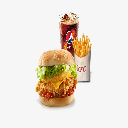

In [22]:
img =load_img('web_pics/fastfood_meal.jpg', target_size=(128,128))
preds = model.predict(np.array([img_to_array(img)/255]))
print(class_labels.iloc[np.argmax(preds[0])])
img

## Detect Food Image

In [82]:
import cv2

In [85]:
model = loaded_model

In [87]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            # yield the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])
            
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w,w))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image
def non_max_suppression(boxes, probs=None, overlapThresh=0.1):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = area

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

def detect_food(img):
    class_labels = pd.read_csv('./labels/category.txt', sep='\t')
    class_labels.id = class_labels.id.astype(str)
    text_labels = class_labels.sort_values('id')
    WIDTH = 128
    PYR_SCALE = 1.5
    WIN_STEP = 16
    ROI_SIZE = (128,128)
    INPUT_SIZE = (128, 128)
    rois = []
    locs = []
    (H, W) = img.shape[:2]
    pyramid = image_pyramid(img, minSize=(128,128))
    for image in pyramid:
        scale = W / float(image.shape[1])
        for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
            x = int(x * scale)
            y = int(y * scale)
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roiOrig, INPUT_SIZE)
            roi = img_to_array(roi)
            rois.append(roi)
            locs.append((x, y, x + w, y + h))
            
    import time
    # convert the ROIs to a NumPy array
    rois = np.array(rois, dtype="float32")
    # classify each of the proposal ROIs and print how long the classifications took
    print("[INFO] classifying ROIs...")
    start = time.time()
    preds = model.predict(rois)
    end = time.time()
    print("[INFO] classifying ROIs took {:.5f} seconds".format(
        end - start))
    
    bbox_predictions = {}
    prediction_scores = {}

    for i, p in enumerate(preds):
        # grab the prediction information for the current ROI
        predicted_label = np.argmax(p)

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if p[predicted_label] >= 0.995:
            prediction_scores[str(predicted_label)]=p[predicted_label] 

            # grab the bounding box associated with the prediction and
            # convert the coordinates
            box = locs[i]
            predicted_label_text = text_labels.iloc[predicted_label][0]

            L = bbox_predictions.get(predicted_label_text, [])
            L.append((box, p[predicted_label]))
            bbox_predictions[predicted_label_text] = L
    
   
    clone = img.copy()

    for item in bbox_predictions.keys():

        boxes = np.array([p[0] for p in bbox_predictions[item]])
        proba = np.array([p[1] for p in bbox_predictions[item]])
        boxes = non_max_suppression(boxes,proba)

        print('[FOOD DETECTED] ' +  item + ' ' + str(proba.max()))
        for (startX, startY, endX, endY) in boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, item, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            break

    plt.imshow(np.clip(clone, a_max = 1, a_min=0))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 5.22204 seconds
[FOOD DETECTED] 88 0.99693054
[FOOD DETECTED] 23 0.9999763
[FOOD DETECTED] 97 0.9962339


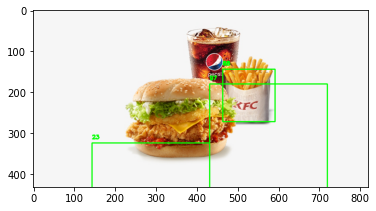

In [88]:
img = load_img('web_pics/fastfood_meal.jpg')
img = img_to_array(img)/255
detect_food(img)